A loja vende mais no verão?

In [2]:
from google.colab import drive 
from scipy.stats import zscore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Coleta dos dados

In [4]:
df = pd.read_csv('/content/drive/MyDrive/datasets/compras_loja_praia.csv')

In [ ]:
df.head()

In [ ]:
df.info()

In [7]:
df.describe()

,idade_cliente,quantidade,preco_unitario
count,5024.000000,10050.000000,10050.00000
mean,48.223328,39.355821,107.25190
std,75.296911,446.253014,53.73199
min,16.000000,1.000000,0.01000
25%,30.000000,2.000000,61.50250
50%,42.000000,4.000000,106.62000
75%,56.000000,5.000000,153.42000
max,999.000000,9999.000000,199.99000


No dataset, a coluna idade do cliente chama atenção porque o desvio padrão é quase o dobro da média. Isso indica uma dispersão muito alta e sugere a presença de outliers. Além disso, apenas cerca de 49% dos dados estão preenchidos, o que limita bastante as análises com essa variável e pode exigir tratamento ou até exclusão da coluna, dependendo do objetivo.

Na coluna quantidade, todos os valores estão preenchidos. A média é 39, mas o desvio padrão é 446 — mais de 10 vezes maior. Essa diferença é muito grande e praticamente confirma a existência de outliers. Porém, os quartis parecem consistentes.

Já na coluna preço unitário, os dados estão completos e, no geral, parecem coerentes. O único ponto de atenção é o valor mínimo de 0,01, que pode indicar erro de registro.

# Observação dos dados

In [8]:
df.isna().sum()

,0
id_compra,0
data_compra,0
cliente_id,0
idade_cliente,5026
genero_cliente,2495
produto,0
quantidade,0
preco_unitario,0
cidade,5027


Como nas colunas "cidade" e "idade_cliente" está faltando mais de 50% dos dados, não será possícel utilizá-las para a análise.

In [9]:
df.duplicated().sum()

np.int64(50)

### Idade

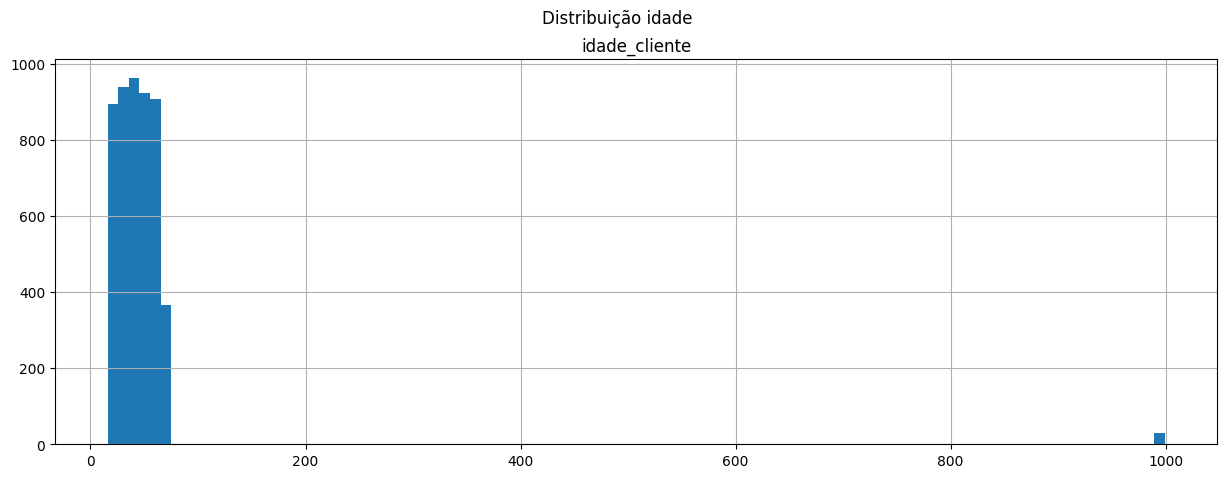

In [10]:
df[["idade_cliente"]].hist(bins = 100, figsize=(15,5))
plt.suptitle("Distribuição idade")
plt.show()

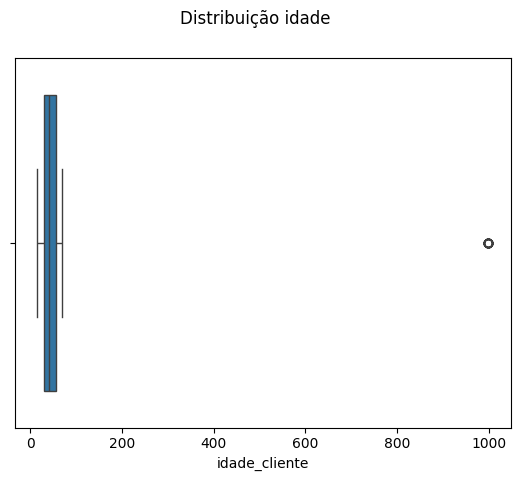

In [11]:
sns.boxplot(x = df["idade_cliente"])
plt.suptitle("Distribuição idade")
plt.show()

O boxplot foi criado para poder analisar os outilers e a sua quantidade. Como podemos ver no gráfico, apenas um outlier existe, no valor de quase 1000 anos.

### Preço unitário

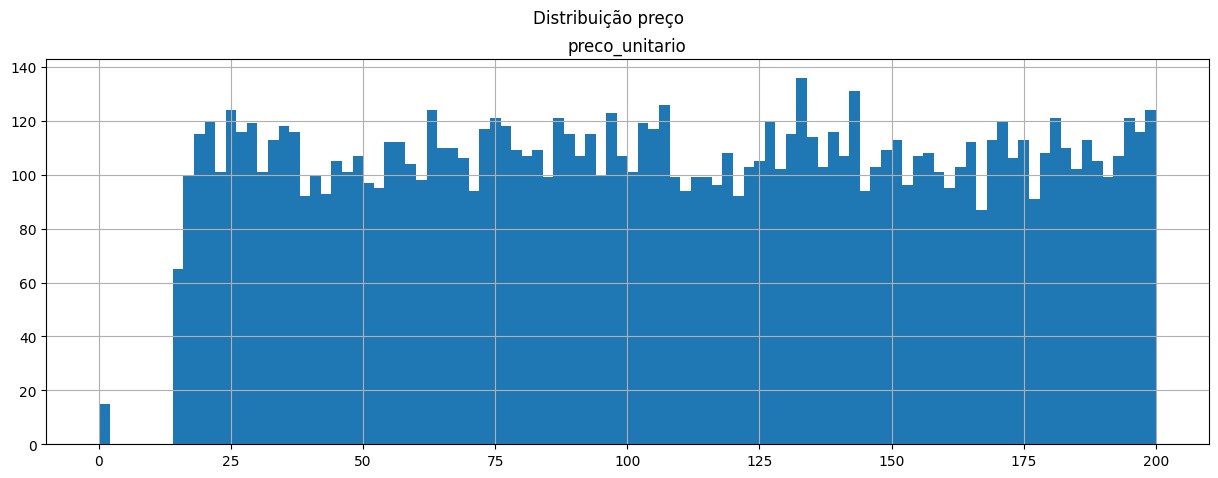

In [12]:
df[["preco_unitario"]].hist(bins = 100, figsize=(15,5))
plt.suptitle("Distribuição preço")
plt.show()

Pelo histograma, podemos ver que temos quase 20 discrepâncias (valor sem sentido) com o valor de, aproximadamente, 0.

### Quantidade

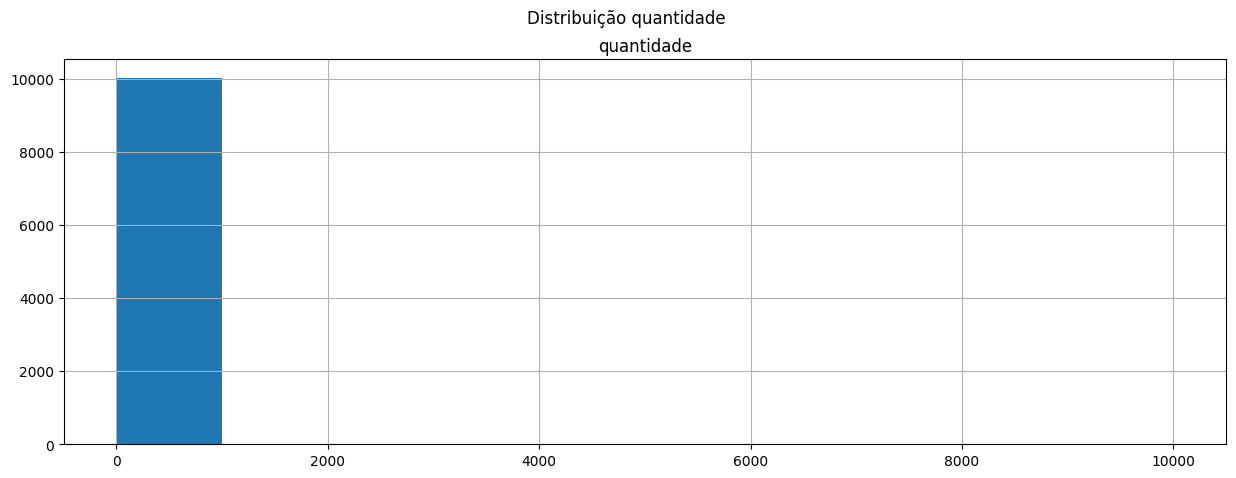

In [13]:
df[["quantidade"]].hist(bins = 10, figsize=(15,5))
plt.suptitle("Distribuição quantidade")
plt.show()

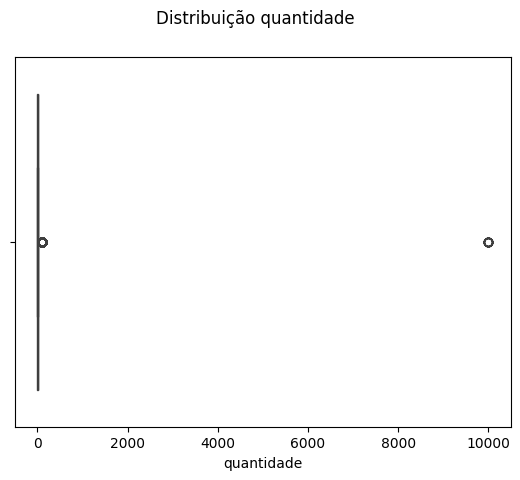

In [14]:
sns.boxplot(x = df["quantidade"])
plt.suptitle("Distribuição quantidade")
plt.show()

Pelo boxplot, conseguimos ver que essa coluna está com dados bem distorcidos. Porém, possui apenas 2 valores de outliers.

# Tratamento

* Arrumar data 
* Replace de gênero 
* Tratar outlier de quantidade
* Tratar discrepância de preço unitário
* Tratar duplicatas

### Arrumar data

In [15]:
df["data_compra_corrigida"] = pd.to_datetime(df["data_compra"], errors="coerce") # Corrigir tipo do campo data

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10050 entries, 0 to 10049
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id_compra              10050 non-null  object        
 1   data_compra            10050 non-null  object        
 2   cliente_id             10050 non-null  object        
 3   idade_cliente          5024 non-null   float64       
 4   genero_cliente         7555 non-null   object        
 5   produto                10050 non-null  object        
 6   quantidade             10050 non-null  int64         
 7   preco_unitario         10050 non-null  float64       
 8   cidade                 5023 non-null   object        
 9   data_compra_corrigida  10030 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 785.3+ KB


Podemos ver que a nova coluna "data_compra_corrigida" foi criada com sucesso e é um datetime. Porém, ela possui 20 valores a menos que a coluna original. Como é menos de 1% da quantidade total, não há problemas.

### Replace de gênero

In [17]:
df["genero_cliente"] = df["genero_cliente"].fillna("Não informado") # Preenchimento de gêneros ausentes com "Não informado"

### Outlier quantidade

In [ ]:
# Calculo de outlier usando IQR
Q1 = df['quantidade'].quantile(0.25)
Q3 = df['quantidade'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# O que estiver abaixo ou acima de algum imite, é considerado outlier

outliers_iqr = df[(df['quantidade'] < limite_inferior) | (df['quantidade'] > limite_superior)]
outliers_iqr

Com o IQR, temos 17% de outliers, valor considerado extremamente alto. Isso sugere que ele não está calculando da maneira mais adequadas para esse dataset e, com isso, calcularemos de outra forma usando o z-score.

In [ ]:
# Calculo de outliers com z-score
df["quantidade_zscore"] = zscore(df['quantidade'])
outliers_z = df.copy()
outliers_z = outliers_z[outliers_z["quantidade_zscore"] > 3]
outliers_z.describe()

In [ ]:
# Retirar outliers de quantidade
df = df[df["quantidade_zscore"] < 3]
df.describe()

### Discrepância de preço unitário

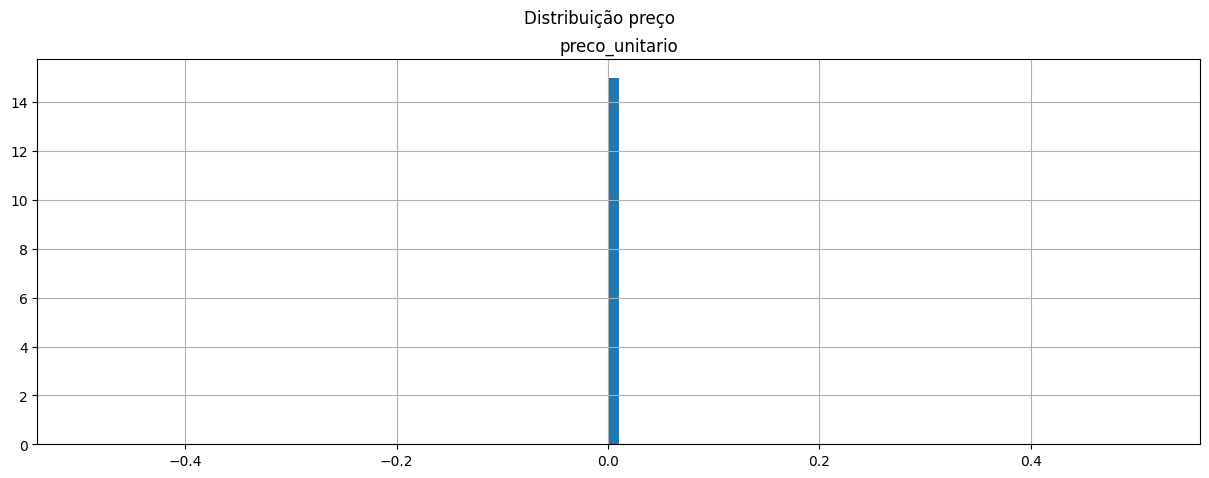

In [21]:
# Verificar discrepância
df_zoom_25 = df.copy()
df_zoom_25 = df_zoom_25[df_zoom_25["preco_unitario"] < 1]


df_zoom_25[["preco_unitario"]].hist(bins = 100, figsize=(15,5))
plt.suptitle("Distribuição preço")
plt.show()

Como são 15 unidades que possuem essa discrepância, poderíamos apenas removê-las, já que seriam menos de 0,3% do total. Porém, outra forma de tratá-las seria com o replace.

In [ ]:
# Substituição
Q1_preco = df['preco_unitario'].quantile(0.25)
df["preco_unitario"] = df["preco_unitario"].replace(0.01, Q1)
df.describe()

### Limpar ausentes da data

In [23]:
df = df.dropna(subset=["data_compra_corrigida"])

# EDA


* Vende mais no verão? sim
* O que muda do verão para as outras estações? os clientes compram em maior quantidade

In [24]:
# Gerar df tratado apenas com colunas úteis
df_tratado = df[['id_compra', 'cliente_id',
        'produto', 'quantidade', 'preco_unitario',
       'data_compra_corrigida']]

In [ ]:
# Criar colunas de mês e ano
df_tratado["mes"] = df_tratado["data_compra_corrigida"].dt.month
df_tratado["ano"] = df_tratado["data_compra_corrigida"].dt.year
df_tratado

In [ ]:
# Criar coluna de estação com base no mês do hemisfério sul
df_tratado["estacao"] = df_tratado["mes"].map({1: "Verão", 2: "Verão", 3: "Outono", 4: "Outono", 5: "Outono", 6: "Inverno", 7: "Inverno", 8: "Inverno", 9: "Primavera", 10: "Primavera", 11: "Primavera", 12: "Verão"})


In [ ]:
# Criar coluna do total vendido para análise
df_tratado["valor_total"] = df_tratado["quantidade"] * df_tratado["preco_unitario"]
df_tratado.head()

In [33]:
# Análise de valor vendido por estação 
vendas_estacao = df_tratado.groupby("estacao")["valor_total"].sum()
vendas_estacao

,valor_total
estacao,
Inverno,4984227.32
Outono,5293393.96
Primavera,5134032.44
Verão,5403685.87


In [29]:
# Análise de quantidade de compradores por estação
clientes_estacao = df_tratado.groupby("estacao")["cliente_id"].nunique()
clientes_estacao

,cliente_id
estacao,
Inverno,2473
Outono,2538
Primavera,2475
Verão,2474


Como podemos ver, a quantidade de clientes nas diferentes estações praticamente se mantém constante. Isso nos leva a pensar que é o ticket médio que aumenta no verão.

In [30]:
# Análise de ticket médio por estação
ticket_estacao = df_tratado.groupby("estacao")["valor_total"].mean()
ticket_estacao

,valor_total
estacao,
Inverno,2004.112312
Outono,2079.102105
Primavera,2061.032694
Verão,2173.646770


In [31]:
# Análise de quantidade de itens comprados por estação
quantidade_estacao = df_tratado.groupby("estacao")["quantidade"].mean()
quantidade_estacao

,quantidade
estacao,
Inverno,19.594290
Outono,19.309505
Primavera,19.004014
Verão,20.096943


In [32]:
# Análise do preço unitário por estação
preco_estacao = df_tratado.groupby("estacao")["preco_unitario"].mean()
preco_estacao

,preco_unitario
estacao,
Inverno,107.411749
Outono,108.913940
Primavera,104.959177
Verão,107.869308


Chegamos a conclusão que no verão há mais lucro, porém não é porque existem mais clientes comprando ou porque estão comprando itenis mais caros, e sim porque a média de compras por cliente aumenta.